In [1]:
import os
import sys
import re
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from Bio import SeqIO
from datetime import datetime
from numpy.random import randint
import torch
import torch.utils.data
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# print(torch.__version__)
# print(torch.cuda.device_count())
# torch.cuda.is_available()

1.9.0+cu102
0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [20]:
# Add Cuda availability

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device, batchSize, *args, **kwargs):
        super(DeviceDataLoader, self).__init__(dl, batchSize, *args, **kwargs)
        self.dl = dl
        self.device = device
        # for b in self.dl: 
        #   yield to_device(b, self.device)
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        # super(DeviceDataLoader, self).__iter__()
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)



cuda


In [21]:
k = 7

In [22]:
# !cp  '/content/drive/Shareddrives/FYP/Colab Notebooks/NEW_Approach/Python Files/WeightsCreator.py' '/content'
# !cp  '/content/drive/Shareddrives/FYP/Colab Notebooks/NEW_Approach/Python Files/HDF5dataset.py' '/content'
from HDF5dataset import HDF5Dataset
from WeightsCreator import make_weights_for_balanced_classes

In [23]:
inputFeatures = int((4**k) / 2)
# inputFeatures = 2
layer_array = [512, 512, 256, 256]
outputSize = 10
momentum = 0.4
dropoutProb = 0.5
batchSize = 200
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
num_workers = 2

In [24]:
trainingDataset = HDF5Dataset('/content/drive/Shareddrives/FYP/DataSets/DataLoader Datasets/34-plasmid_TestDataset', True, False)
datasetsize = len(trainingDataset)
train_size = int(0.8 * len(trainingDataset))
val_size = len(trainingDataset) - train_size
                     
train_ds, val_ds = random_split(trainingDataset, [train_size, val_size])
tens = torch.tensor([int(label) for _, label in train_ds])
weights = make_weights_for_balanced_classes(outputSize, tens)
# weights = weights
# weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, datasetsize)

train_dl = DataLoader(train_ds, batchSize, shuffle=False, num_workers=num_workers, pin_memory=True, sampler=sampler)
val_dl = DataLoader(val_ds, batchSize, num_workers=num_workers, pin_memory=True)

# train_dl = DeviceDataLoader(train_ds, device, batchSize, shuffle=False, num_workers=num_workers, pin_memory=True, sampler=sampler)
# val_dl = DeviceDataLoader(val_ds, device, batchSize, num_workers=num_workers, pin_memory=True)

In [25]:
# index = 0
# for i in train_dl:
#   print("\n")
#   print(i[0])
#   print("\n")
#   print(i[1])
#   break

  
# train_dl = DeviceDataLoader(train_ds, device, batchSize, shuffle=False, num_workers=num_workers, pin_memory=True, sampler=sampler)
# val_dl = DeviceDataLoader(val_ds, device, batchSize, num_workers=num_workers, pin_memory=True)

# index = 0
# for i in train_dl:
#   print("\n")
#   print(i[0])
#   print("\n")
#   print(i[1])
#   break

# print(type(train_ds))

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

class Model(nn.Module):
    def __init__(self, in_size, layer_array = [512, 512, 256, 256], out_size = 28):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, layer_array[0]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[0], layer_array[1]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[1], layer_array[2]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[2], layer_array[3]),
          nn.ReLU(),
          # nn.Dropout(dropoutProb),
          nn.Linear(layer_array[3], out_size)
        )
        
    def forward(self, xb):
        softmax = nn.LogSoftmax(dim=0)
        return softmax(self.network(xb))

    def training_step(self, batch):
        values, labels = batch 
        values = values.to(device)
        labels = labels.to(device)
        out = self(values)                  # Generate predictions
        loss = nn.functional.nll_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        values, labels = batch 
        values = values.to(device)
        labels = labels.to(device)
        out = self(values)                    # Generate predictions
        loss = nn.functional.nll_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def predict_image(value, model):
  xb = value
  # //:TODO Check torch.stack
  # xb = torch.stack(value)
  yb = model(xb)
  _, preds  = torch.max(yb, dim=0)
  return preds

def predict_image(value, model):
    # Convert to a batch of 1
    xb = to_device(value, device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


In [27]:
model = Model(inputFeatures, layer_array, outputSize)
model = to_device(model, device)
model

Model(
  (network): Sequential(
    (0): Linear(in_features=8194, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [28]:
model.double()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 0.0000, val_acc: 0.7143
Epoch [1], val_loss: 0.0000, val_acc: 0.7143


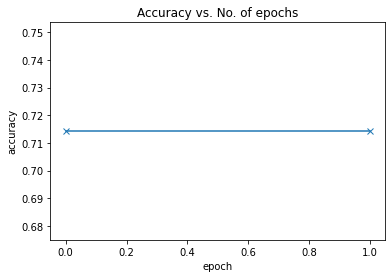

In [29]:
plot_accuracies(history)

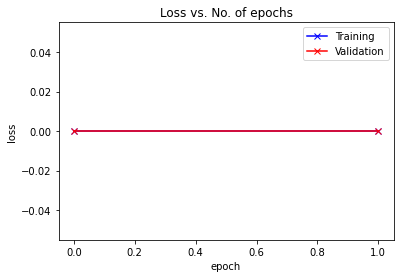

In [30]:
plot_losses(history)

In [31]:
predict_image(torch.from_numpy(train_ds([0][0]), model) , train_ds([0][1]))

TypeError: ignored